%%latex
\begin{center}
\author{Jonathan Bryan, Carmen Dekmezian}
\end{center}

# Abstract
Partial least squares (PLS) is a practical algorithm for regression when modeling high-dimensional data that includes high collinearity. PLS was developed in the mid-20th century by the econometrician Herman Wold and subsequently widely adopted as a tool for the quantitative analysis of compounds in chemistry. PLS has the capacity for high predictive accuracy as it decomposes the matrix of predictor and response values into two separate blocks. These separate blocks represent latent factors or components that most account for the variation within the data. This process is guided by an inner relation between predictor scores, response scores, and regression coefficient that assures each decomposition of components maximizes its relationship to the response variable and includes information from the previous component. The model then normally uses a lower dimensional subspace of the design matrix to predict future response values, a projection of the latent structure. This gives the PLS high predictive capacity but lower ability for interpretation of components and therefore important variables. In this report, PLS is used to model housing data from Ames, Iowa which incorporates several predictors of different housing attributes to predict home price. Comparison of PLS to principal component regression (PCR), and ordinary least squares (OLS) is done. Simulated data that includes more predictors than observations and high collinearity are produced and latent components are recovered using PLS to allow for prediction. Finally, optimization of the algorithm is demonstrated using just-in-time programming and efficient functional and memory technique.

Our code can be found in the github repository: https://github.com/cdek11/PLS

# Background
The paper we selected is titled “Partial Least Squares Regression: A Tutorial” by Geladi and Kowalski.$^1$ It discusses partial least squares regression (PLSR), which is a method for decomposing values of predictors and response into more basic components and finding a robust linear relationship between the two components. PLSR was formulated by econometrician Herman Wold as a technique for "soft modelling", when the number of variables is high, the relationship between the variables is poorly understood and prediction is the primary goal.$^2$ His son Svante Wold extended the use of PLSR to chemometrics to model high dimensional chemical data.

The nonexistence of a unique solution when the number of predictors is larger than the sample size of the data is a challenging problem in multiple linear regression, especially when multicollinearity and missing are also issues. Other methods that seek to reduce the dimensionality of the predictors, such as principal component analysis (PCR), allow for noise reduction and solve the collinearity problem. However, useful information for accurate prediction can be lost because PCR explains the useful directional information in the predictor space which may not be sufficiently linked to the space of new observed responses.

PLSR produces X-scores, much like PCR, but also Y-scores that explain the given response space. These scores are generated by seeking important directions in the X-scores that are strongly associated with variation in the Y-scores and biased towards accurate predictions.

PLSR has several advantages over other methods. It is advantageous when the number of predictors is larger than the sample size and collinearity is high among the predictors. It is also a robust method regression because it reduces out of sample variance of residual errors and noise in the data in comparison to common multiple least squares regression algorithms. Additionally, it is beneficial when there are missing observations in the data. 

One disadvantage of PLSR is that the use of lower dimensional representations of the data and loadings of the model can make the interpretability of the important latent predictors difficult in some situations.

## Description of algorithm

PLS is a regression method used to overcome limitations discussed above for normal linear regressions (e.g., many collinear predictors, more predictors than samples, etc.) by mapping observed sets of observed variables to response variables by means of latent variables.$^3$ Essentially the model assumes that the data is generated by an underlying model directed by a smaller number of latent variables in the data. 

First, two sets of latent variables are extracted from the data: $T$ (or x-scores) from the predictors, and $U$ (or y-scores) from the response variable. These latent vectors are determined through maximizing the covariance between different sets of variables. 

For the classic linear regression, we try to solve the equation, $Y = X\beta + \epsilon$, where the ordinary least squares estimate for $\beta$ is identified as $(X^T X)^{-1} X^TY$.$^4$ This estimate is obtained by minimizing the sum of squared residuals. However, models that have predictors with high collinearity or more predictors than observations can result in singularity of the matrix $(X^T X)$. As an alternative and way to fix this issue, we implement the PLS algorithm throught the following steps$^2$:

1) Start with vector $u$. If there is only one response variable, then $u = y$, otherwise it is one of the columns of $Y$.

2) Calculate the weights for the predictors ($X$).
$$w = \frac{X^Tu}{u^Tu}$$

3) Normalize the weights for the predictors ($X$).
$$w = \frac{w}{||w||}$$

4) Determine $t$ ($X$ scores).

$$t = \frac{Xw}{t^{T}t} $$

5) Now perform similar calculations for $Y$. Calculate the weights for the response variable.
$$c = \frac{X^Tt}{t^{T}t}$$

6) Normalize the weights for the response ($X$):
$$c = \frac{c}{||c||}$$

7) Determine $u$ ($Y$ scores).
$$u = \frac{Yc}{c^Tc}$$

8) If there is more than one response variable, then we test to determine whether the $t$ values have converged. If the change in $t$ from one iteration to the next, $\frac{||t_{old} - t_{new}||}{||t_{new}||}$, is not smaller than a threshold value, then we iterate through steps 2-5 until convergence is reached.

9) Deflate variables for next iteration.
$$p = \frac{X^Tt}{t^Tt}$$
$$X = X - tp^T$$
$$Y = Y - tc^T$$

10) Calculate the component regression coefficient.
$$ b = \frac{u^{T}t}{t^{T}t}$$

11) Calculate the X and Y residuals for component h
$$E_h = E_{h-1} - t_h p_h; X = E_{0}$$
$$F_h = F_{h-1} - b_h t_h q_{h}^T; Y = F_{0} $$

12) Iterate through components until they are not found to be predictive of $Y$.

In [1]:
# import packages
%matplotlib inline
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# load in ames home price train and test data
ames_train = pd.read_csv("ames_train.csv")
ames_test = pd.read_csv("ames_test.csv")

In [4]:
# merge both files first so there are the same number of categories created
ames_merged = pd.concat([ames_train, ames_test])
ames_merged = pd.get_dummies(ames_merged).fillna(value=0)

# save merged file to csv in folder
ames_merged[0:1500].to_csv("ames_data_train.csv")
ames_merged[1500:2000].to_csv("ames_data_test.csv")

In [5]:
# convert categorical variables to dummy variables
# create variables for train and test data separately, x for predictors, y for response
x_predictors_train = ames_merged[0:1500].drop(["price", "PID"], axis = 1)
x_predictors_test = ames_merged[1500:2000].drop(["price", "PID"], axis = 1)

y_train = ames_train.price
y_test = ames_test.price

# Algorithm: Partial Least Squares

In [6]:
def pls(path, path_test, predictors, response):
    '''Function that takes a dataframe and runs partial least squares on numeric predictors for a numeric response.
    Returns the residuals of the predictor (X block), response (Y block), and traininig RMSE'''
    combined = predictors #Ready list to combine the predictors and response to get both sets of data
    ###Data preparation
    data = pd.DataFrame.from_csv(path) #Retrieve full csv data from local machine
    combined.append(response) #Add the response to the list of variables to get from data set
    data = data[combined] #Only retrieve the predictors and response
    response_std = data[response].std() #Store the response variable standard deviation to scale the RMSE to real units at end
    
    #Subtract the mean from each column
    data = data - data.mean()

    #Scale each column by the column standard deviation
    data = data/data.std()

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop() #Remove the response variable from the predictors list
    X = data[predictors].as_matrix() #Create a matrix of predictor values
    Y = data[[response]].as_matrix() #Create a matrix of predictor values
    Y_true = Y #Store the true Y values for prediction later
    
    #Get rank of matrix
    rank = np.linalg.matrix_rank(X) #Store rank of matrix because this is the maximum number of components the model can have
    
    #PLS algorithm
    u = Y #Set intital u value as response variables
    Xres_dictionary = {} #Create a dictionary for the residuals from the decomposition of the X block
    Yres_dictionary = {} #Create a dictionary for the residuals from the decomposition of the Y block
    q_new_dictionary ={} #Create a dictionary for row vectors of q loadings for the Y block
    b_dictionary = {} #Create a dictionary for scalar regression coefficient for PLS components 
    t_hat_dictionary = {} #Create a dictionary for the matrix of X scores 
    t_hat_train_dictionary = {} #Create a dictionary for the matrix of X scores for training data
    t_hat_test_dictionary = {} #Create a dictionary for the matrix of X scores for test data
    RMSE_dictionary = {} #Create a dictionary to store RMSE for training data
    RMSE_test_dictionary = {} #Create a dictionary to store RMSE for test data
    for i in range(1,(rank+1)):
        Y_pred = np.zeros((Y_true.shape[0],1))
        #Here we have one variable in the Y block so q = 1 
        #and omit steps 5-8
        q = 1

        #For the X block, u = Y
        u = Y #random y column from Y #Step 1
        w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
        w_new = w_old/np.linalg.norm(w_old) #Step 3
        t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

        #For the Y block can be omitted if Y only has one variable
        q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
        q_new = q_old/np.linalg.norm(q_old) #Step 6
        q_new_dictionary[i] = q_new
        u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

        #Step 8: Check convergence

        #Calculate the X loadings and rescale the scores and weights accordingly
        p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
        p_new = p.T/np.linalg.norm(p.T) #Step 10
        t_new = t/np.linalg.norm(p.T) #Step 11
        w_new = w_old/np.linalg.norm(p)  #Step 12

        #Find the regression coefficient for b for th inner relation
        b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
        b_dictionary[i] = b

        #Calculation of the residuals
        E_h = X - np.dot(t_new,p_new.T)
        F_h = Y - b.dot(t_new.T).T.dot(q)
        
        #Set outer relation for the X block
        Xres_dictionary[i] = E_h
        X = E_h
        
        #Set the mixed relation for the Y block
        Yres_dictionary[i] = F_h
        Y = F_h
        
        #Find estimated t hat
        t_hat = np.dot(E_h,w_new.T)
        t_hat_dictionary[i] = t_hat
        E_h = E_h - np.dot(t_hat,p_new.T)
        
        #Predict training set response by summing over different compenents
        E_h = X
        for j in range(1,i+1):
            t_hat_train = np.dot(E_h,w_new.T)
            t_hat_train_dictionary[j] = t_hat_train
            E_h = E_h - np.dot(t_hat_train, p_new.T)
            for g in range(1,i+1):
                Y_pred = Y_pred + (b_dictionary[g]*t_hat_dictionary[g]).dot(q_new_dictionary[g].T)
        
        #Find training RMSE 
        RMSE = np.sqrt(sum((Y_true - Y_pred)**2)/Y_true.shape[0]) 
        RMSE_scaled = RMSE * response_std 
        RMSE_dictionary[i] = RMSE_scaled
        
        #Code chunk to find test RMSE
        #Load data
        data_test = pd.DataFrame.from_csv(path_test)
        combined.append(response)
        data_test = data_test[combined]
        response_std_test = data_test[response].std()
    
        #Subtract the mean from each column
        data_test = data_test - data_test.mean()

        #Scale each column by the column standard deviation
        data_test = data_test/data_test.std()

        #Separate in to design matrix (X block) and response column vector (Y block)
        predictors.pop()
        X_test = data[predictors].as_matrix()
        Y_test = data[[response]].as_matrix()
        Y_true_test = Y_test #For prediction
        
        Y_pred_test = np.zeros((Y_true_test.shape[0],1)) 
        
        #Get rank of matrix
        rank_test = np.linalg.matrix_rank(X)
        
        E_h_test = X_test
        
        #Sum over different compenents
        for k in range(1,i+1):
            t_hat_test = np.dot(E_h_test,w_new.T)
            t_hat_test_dictionary[k] = t_hat_test
            E_h_test = E_h_test - np.dot(t_hat_test, p_new.T)
            Y_pred_test = Y_pred_test + (b_dictionary[k]*t_hat_test_dictionary[k]).dot(q_new_dictionary[k].T)
        
        #Find test RMSE 
        RMSE = np.sqrt(sum((Y_true_test - Y_pred_test)**2)/Y_true_test.shape[0]) 
        RMSE_scaled_test = RMSE * response_std_test # I believe this is the RMSE since the Y had to be scaled.
        RMSE_test_dictionary[i] = RMSE_scaled_test
        
    return RMSE_dictionary, RMSE_test_dictionary

# Describe optimization for performance

In our initial version of the PLS algorithm, we tried to utilize numpy as much as possible, especially when dealing with matrices. In class, we learned about two common methods to compile the python code that we write, Just-In-Time (JIT) and Cython for Ahead-of-Time (AOT) compilation, but we ultimately decided to use the JIT approach. We first identified certain chunks of our main PLS function that could be easily separated and put them into their own functions. Then we used the @jit command before those specific functions, which allowed numba to effectively figure out when and how the code should be optimized. We ran our test data on both the initial PLS algorithm and then on the optimized version of the PLS algorithm for speed and accuracy.

In [47]:
import numba
from numba import jit

@jit
def mean_center_scale(dataframe):
    '''Scale dataframe by subtracting mean and dividing by standard deviation'''
    dataframe = dataframe - dataframe.mean()
    dataframe = dataframe/dataframe.std()
    return dataframe

@jit
def y_pred(Y_pred, i,b_dictionary,t_hat_dictionary,q_new_dictionary):
    '''Find prediction for Y based on the number of components in this iteration'''
    for j in range(1,i+1):
        Y_pred = Y_pred + (b_dictionary[j]*t_hat_dictionary[j]).dot(q_new_dictionary[j].T)
    return Y_pred    

@jit
def rmse(i,Y_true, Y_pred, response_std, RMSE_dictionary):
    '''Find training RMSE''' 
    RMSE = np.sqrt(sum((Y_true - Y_pred)**2)/Y_true.shape[0])
    RMSE_scaled = RMSE * response_std 
    RMSE_dictionary[i] = RMSE_scaled

    return RMSE_dictionary

@jit        
def core_pls(i,Y, X, q_new_dictionary, b_dictionary, t_hat_dictionary) :
    '''Core PLS algorithm'''
    
    #Here we have one variable in the Y block so q = 1 
    #and omit steps 5-8
    q = 1

    #For the X block, u = Y
    u = Y #random y column from Y #Step 1
    w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
    w_new = w_old/np.linalg.norm(w_old) #Step 3
    t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

    #For the Y block can be omitted if Y only has one variable
    q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
    q_new = q_old/np.linalg.norm(q_old) #Step 6
    q_new_dictionary[i] = q_new
    u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

    #Step 8: Check convergence

    #Calculate the X loadings and rescale the scores and weights accordingly
    p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
    p_new = p.T/np.linalg.norm(p.T) #Step 10
    t_new = t/np.linalg.norm(p.T) #Step 11
    w_new = w_old/np.linalg.norm(p)  #Step 12

    #Find the regression coefficient for b for th inner relation
    b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
    b_dictionary[i] = b

    #Calculation of the residuals
    E_h = X - np.dot(t_new,p_new.T)
    F_h = Y - b.dot(t_new.T).T.dot(q) #WORKS BUT IS THIS RIGHT?        
    
    #Set outer relation for the X block
    #Xres_dictionary[i] = E_h #MAYBE REMOVE
    X = E_h
        
    #Set the mixed relation for the Y block
    #Yres_dictionary[i] = F_h 3MAYBE REMOVE
    Y = F_h
        
    #Find estimated t hat
    t_hat = np.dot(E_h,w_new.T)
    t_hat_dictionary[i] = t_hat
    E_h = E_h - np.dot(t_hat,p_new.T)
    
    return X,Y, u, w_new, q_new, t_new, p_new, q_new_dictionary, t_hat_dictionary, b_dictionary,E_h, F_h 
          

def pls_optimized(path, path_test, predictors, response):
    '''Function that takes a dataframe and runs partial least squares on numeric predictors for a numeric response.
    Returns the residuals of the predictor (X block), response (Y block), and traininig RMSE'''
    ###TRAINING DATA
    combined = predictors
    #Load data
    data = pd.DataFrame.from_csv(path)
    combined.append(response)
    data = data[combined]
    response_std = data[response].std()
    
    #Subtract the mean and scale each column
    data = mean_center_scale(data)

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop()
    X = data[predictors].as_matrix()
    Y = data[[response]].as_matrix()
    Y_true = Y #For prediction
    
    #Get rank of matrix
    rank = np.linalg.matrix_rank(X)
   
    u = Y #set initial u as Y
    Xres_dictionary = {}
    Yres_dictionary = {}
    q_new_dictionary ={}
    b_dictionary = {}
    t_hat_dictionary = {}
    t_hat_train_dictionary = {}
    t_hat_test_dictionary = {}
    RMSE_dictionary = {}
    RMSE_test_dictionary = {}
    
    ###TEST DATA
    #Load data
    data_test = pd.DataFrame.from_csv(path_test)
    combined.append(response)
    data_test = data_test[combined]
    response_std_test = data_test[response].std()
    
    #Subtract the mean and scale each column
    data_test = mean_center_scale(data_test)

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop()
    X_test = data[predictors].as_matrix()
    Y_test = data[[response]].as_matrix()
    Y_true_test = Y_test #For prediction
      
    #Get rank of matrix
    rank_test = np.linalg.matrix_rank(X_test)
    
    #Iterate through each component
    for i in range(1,(rank+1)):
        Y_pred = np.zeros((Y_true.shape[0],1))
        Y_pred_test = np.zeros((Y_true_test.shape[0],1))
        
        #Core algo
        X,Y, u, w_new, q_new, t_new, p_new, q_new_dictionary, t_hat_dictionary, b_dictionary,E_h, F_h = core_pls(i,Y, X, q_new_dictionary, b_dictionary, t_hat_dictionary)
                
        #NEW Sum over different compenents
        for g in range(1,i+1):
            t_hat_train = np.dot(E_h,w_new.T)
            t_hat_train_dictionary[g] = t_hat_train
            E_h = E_h - np.dot(t_hat_train, p_new.T)
            Y_pred = y_pred(Y_pred, g,b_dictionary,t_hat_dictionary,q_new_dictionary)
        
        #Find training RMSE 
        RMSE_dictionary = rmse(i,Y_true, Y_pred, response_std, RMSE_dictionary)
        
        #Set initial E_h as X_test data
        E_h_test = X_test
        
        #Sum over different compenents
        for k in range(1,i+1):
            t_hat_test = np.dot(E_h_test,w_new.T)
            t_hat_test_dictionary[k] = t_hat_test
            E_h_test = E_h_test - np.dot(t_hat_test, p_new.T)
            Y_pred_test = y_pred(Y_pred_test, k,b_dictionary,t_hat_test_dictionary,q_new_dictionary)
        
        #Find test RMSE 
        RMSE_test_dictionary = rmse(i,Y_true_test, Y_pred_test, response_std_test, RMSE_test_dictionary)
        
    return RMSE_dictionary, RMSE_test_dictionary

# Applications to simulated data sets

Since the PLS method is especially beneficial to use when one is performing regressions on a dataset with 1) more predictors than observations, and 2) highly correlated variables, we decided to simulate a dataset that played to these strengths. Our simulated data contained 11 predictors (x1-x11), where x4-x11 were functions of the first three variables (i.e., they were correlated) and one response variable (y) that was only a function of two of the predictors. Additionally, our training and test dataset only contained 10 observations each, so one value less than the number of predictors.

In [48]:
# generate dataset with 11 predictors (x1-x11) and a response variable y, with only 10 observations in each dataset.
# variables are made to be correlated with one another and response variable doesn't rely on all variables. 
np.random.seed(9856)
x1 = np.random.normal(5, .2, 20)
x2 = np.random.normal(7, .4, 20)
x3 = np.random.normal(9, .8, 20)

sim_data = {'x1' : x1,
            'x2' : x2, 
            'x3' : x3,
            'x4' : 5*x1,
            'x5' : 2*x2,
            'x6' : 4*x3,
            'x7' : 6*x1,
            'x8' : 5*x2,
            'x9' : 4*x3,
            'x10' : 2*x1,
            'x11' : 3*x2,
            'y' : 6*x1 + 3*x2}

# convert data to csv file
pd.DataFrame(sim_data)[0:10].to_csv("sim_data_train.csv")
pd.DataFrame(sim_data)[10:20].to_csv("sim_data_test.csv")

In [9]:
# set variables for input to pls function
sim_predictors = pd.DataFrame(sim_data).drop("y", axis = 1).columns.tolist()
sim_response = "y"
sim_data_path = 'sim_data_train.csv'
sim_data_test_path = 'sim_data_test.csv'

# run pls regression on simulated data
pls_sim_results = pls(sim_data_path, sim_data_test_path, sim_predictors, sim_response)

In [49]:
# run pls optimized regression on simulated data
pls_optimized_sim_results = pls_optimized(sim_data_path, sim_data_test_path, sim_predictors, sim_response)

# Applications to real data sets

In the paper we selected, the authors don’t include real-world examples with data that we can test on. Thus, we decided to test the algorithm on a publicly available dataset that we investigated for our predictive modeling class. This data contains information on residential properties in Ames, Iowa, with variables that describe characteristics of each home and a variable indicating the home’s value.$^5$

We decided to use this dataset because it contains many correlated variables, some of which have very similar meanings. Additionally, since there are several different factor/categorical variables in the dataset, the total number of predictors increases when trying to estimate a coefficient for each level. With this data, we were trying to predict a home’s price based on its attributes. The limitations of the data, including the number of predictors and collinearity, suggest that the PLS method will be beneficial for predictions and accuracy.

In [11]:
# set variables for input to pls function
predictors = x_predictors_train.columns.tolist()
response = "price"
path = 'ames_data_train.csv'
path_test = 'ames_data_test.csv'

# run regression using pls code and optimized pls code on ames housing data
pls_reg_results = pls(path, path_test, predictors, response)
pls_reg_opt_results = pls_optimized(path, path_test, predictors, response)

In [12]:
# find speed of initial pls function
pls_reg_speed = %timeit -o -q pls(path, path_test, predictors, response)

In [13]:
# find speed of initial pls function
pls_reg_opt_speed = %timeit -o -q pls_optimized(path, path_test, predictors, response)

In [14]:
# function to get list of values from dictionary input
def get_list(input_dict):
    '''input dictionary with key/values, and then output the list of values'''
    length = len(input_dict)
    x = list(range(1, length + 1 , 1))
    
    mykeys = input_dict.keys() # get keys for dictionary
    value_list =[input_dict[x] for x in mykeys] # get list of values from dictioanry
    value_list = [ int(x) for x in value_list ]
    return value_list

<function matplotlib.pyplot.show>

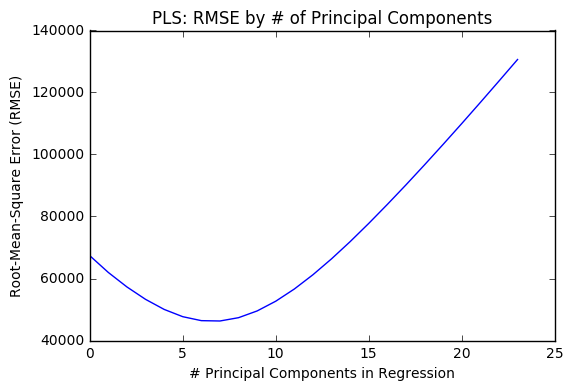

In [34]:
# get list of rmse values from pls regression on ames data
pls_rmse_list = get_list(pls_reg_results[0])

# plot rmse values from pls regression on ames data
plt.plot(pls_rmse_list)
plt.title("PLS: RMSE by # of Principal Components")
plt.xlabel("# Principal Components in Regression")
plt.ylabel("Root-Mean-Square Error (RMSE)")
plt.show

In [16]:
# get minimum rmse values using the pls method and the optimized pls method
pls_rmse_test_list = get_list(pls_reg_results[1])
pls_opt_rmse_test_list = get_list(pls_reg_opt_results[1])

In [17]:
# compare accuracy and speed for the pls method (optimized and not) 
pls_comparison = {'RMSE' : [min(pls_rmse_test_list), min(pls_opt_rmse_test_list)], 'Speed' : [pls_reg_speed.best, pls_reg_opt_speed.best]}
pd.DataFrame(pls_comparison, index=['PLS', 'PLS Optimized'])

,RMSE,Speed
PLS,46178,0.444151
PLS Optimized,46178,0.242239


# Comparative analysis with competing algorithms

With the Ames housing data, we decided to test our PLS results above with the standard OLS regression and the PCR method. In the OLS regression, we tried predicting price using all of the variables in the dataset. The model is as follows:
$$y = X\beta + \epsilon$$
$$y = \beta_0 + x_1\beta_1 + ... + x_p\beta_p + \epsilon$$ 
$$y = \beta_0 + area^*\beta_{area} + ... + Lot.Config^*\beta_{Lot.Config} + \epsilon$$ 
where we have $p$ predictors available in the data.

For the OLS model, $\beta$ is estimated by minimizing the sum of squared errors and can be express as $(X^T X)^{-1} X^TY$. All predictors are used in estimating the $\beta$ coefficients. The PCR regression is similar to the PLS regression in that it selects a subset of features out of the larger number of predictors to include in the model. In the PCR model, the predictors are first scaled and then we perform 10-fold cross-validation on the model with varying numbers of predictors (from 0, which is a model with just the intercept, up to the total number of predictors). We find the model with the smallest RMSE to identify the number of principal components to be used in the final model (see the plot below for a visualization). Using that set of predictors, we predict the house price on the test data and calculate the RMSE.

In implementing the PCR algorithm below, we loosely followed an example conducted by Professor Crouser at Smith College on baseball data.$^6$

### Simple Algorithm: OLS

In [18]:
# function to run the ols regression on a set of input training and test data
def run_ols_reg(x_train, y_train, x_test, y_test):
    '''Run ordinary least squares regression on set of x predictors and y response variable.
    Fit on training data and predict on test data. Output RMSE of model.'''

    # run ols on training data
    ols_reg = lin_reg().fit(x_train, y_train)
    
    # predict on test data and get rmse estimate
    y_test_pred_ols = ols_reg.predict(x_test)
    ols_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_ols))
    
    return ols_rmse_test

# Alternative Algorithm: PCR

In [19]:
# create function to do k-fold cross validation on the input data
def cross_val(x_data, y_data, num_folds):
    '''Perform k-fold cross-validation on training data. Output list of RMSE values'''
    
    # cross validation (k-fold)
    n = len(x_data)
    cross_val_k_10 = cross_validation.KFold(n, n_folds = num_folds, shuffle = True, random_state = 1)
    rmse = []

    # calculate rmse values for intercept (no predictors/components)
    mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), np.ones((n,1)), y_data.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
    rmse.append(sqrt(mean_sq_error))
    
    # calculate rmse values for varying numbers of predictors/components
    for i in range(1, x_data.shape[1]):
        mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), x_data[:,:i], y_data.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
        rmse.append(sqrt(mean_sq_error))
    
    return rmse

In [20]:
def run_pcr_reg(x_train, y_train, x_test, y_test):
    '''Run ordinary least squares regression on set of x predictors and y response variable.
    Fit on training data and predict on test data. Output RMSE (both training and test data).'''

    # scale x train data
    x_scaled_train = PCA().fit_transform(scale(x_train))

    # perform cross-validation on the x scaled data
    pcr_rmse = cross_val(x_scaled_train, y_train, 10)

    # find number of principal components with smallest rmse
    n_pcr_comps = pcr_rmse.index(min(pcr_rmse))

    # run regression using specific number of principal components
    pcr_reg = lin_reg().fit(x_scaled_train[:,:n_pcr_comps], y_train)

    # use regression above to predict on test data
    x_scaled_test = PCA().fit_transform(scale(x_test))[:,:n_pcr_comps]
    y_test_pred_pcr = pcr_reg.predict(x_scaled_test)
    pcr_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_pcr))
    
    # output rmse train/test values for pcr regression
    return pcr_rmse, pcr_rmse_test

In [21]:
# run ols regression on ames data
ols_reg_results = run_ols_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [22]:
# get speed of ols regression on ames data
ols_speed = %timeit -o -q run_ols_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [23]:
# run pcr regression on ames data
pcr_reg_results = run_pcr_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [24]:
# get speed of pcr regression on ames data
pcr_speed = %timeit -o -q run_pcr_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [25]:
# summary of all methods, accuracy and speed
diff_methods_summary = {'RMSE' : [min(pls_rmse_test_list), min(pls_opt_rmse_test_list), pcr_reg_results[1], ols_reg_results], 'Speed' : [pls_reg_speed.best, pls_reg_opt_speed.best, pcr_speed.best, ols_speed.best]}
pd.DataFrame(diff_methods_summary, index=['PLS', 'PLS Optimized', 'PCR', 'OLS'])

,RMSE,Speed
PLS,46178.000000,0.444151
PLS Optimized,46178.000000,0.242239
PCR,67014.500338,0.502869
OLS,40592.231387,0.001790


<function matplotlib.pyplot.show>

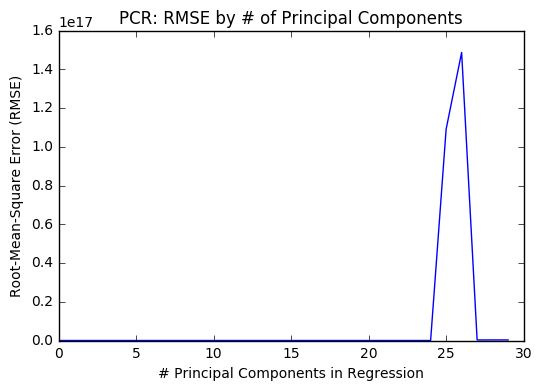

In [35]:
# plot pcr
plt.plot(pcr_reg_results[0])
plt.title("PCR: RMSE by # of Principal Components")
plt.xlabel("# Principal Components in Regression")
plt.ylabel("Root-Mean-Square Error (RMSE)")
plt.show

# Discussion/Conclusion

PLS is a powerful algorithm for linear modeling, particularly in high dimensional settings where the number of predictors is larger than the number of samples. PLS harnesses the power to decompose the matrix of predictors into a lower dimensional settings while making sure that the decomposition is driven by an inner relation between the decomposed matrix and the response variable to assure higher predictor potential. This inner relation is derived from the relationship between the predictor and response matrix scores with a component varying regression coefficient $U_h = b_h t_h$. This interaction between the predictors and response distinguishes PLS from other methods that decompose the predictive space and response space separately, such as PCA. As an iterative procedure, each decomposed and rebuilt component receives the scores and weights of the previous component, often improving predictive accuracy.

Important for PLS model evaluation is the proper selection of the number of components to use in the model. The maximum number of components that can be accessed in PLS is the rank of the design matrix of predictors. The maximum number of components, however, is often not needed in real world data set to the presence of noise and collinearity. In this report, we used the root means squared error (RMSE) of the model used on a test data set in order to determine the proper component level. The training data will often see a lower RMSE as the component level increases, which reflects overfitting of the data, an unfortunate outcome if the intention is to the model for prediction. Historically, PLS has been used in chemometrics to analyze the presence of different compounds contained in test samples. In our model of the Ames, Iowa housing prices, we determined that out of 30 predictors the optimal number of components was 7. This demonstrates the practical use of PLS for applications that use real world data outside of its historical uses.

In addition, the PLS algorithm generates residuals for the predictor matrix ($E_h$)and response variables ($F_h$), which is derived from the difference between the additive decomposition of the respective matrices and the original data matrices. Fh can be interpreted as how much variation the model explains in the response variable while Eh gives an indication of how much of the X block was not used in the model, and therefore how much signal is present in the data.
PLS in comparison to PCR and ordinary least squares fared well, producing an RMSE much lower than PCR and slightly above OLS. In our simulated data, we demonstrate the high-dimensional scenario when the number of observations is lower than the number of predictors and multicollinearity is present. It is demonstrated that PLS allows use to first run the model, which would be impossible using OLS and other methods. In addition, we are able to recover a number of components closer to the true number of variables controlling the data while maintaining high predictive power.

Because this algorithm can deal with matrices of considerable size, and even multiple response variables, speed, and efficiency are important. To optimize our model employed a number of methods including using the efficient mathematical package Numpy for matrix operations, efficient memory allocation, and just-in-time programming using the Numba package to compile the code to LLVM IR which is natively executed at runtime, faster than normal Python code. Through these optimizations we were able to improve our runtime performance of the PLS algorithm by nearly 50 percent.

# References

[1] Geladi, P., and Kowalski, B. R.. 1986. “Partial Least-Squares Regression: a Tutorial,” Analytica Chimica Acta, 185, 1 (1986).

[2] Wold, S. et al. 2001. PLS regression: a basic tool of chemometrics. Chemometr. Intell. Lab. 58: 109–130.

[3] Tobias, R. D.. 2003. An Introduction to partial least squares regression <http://www.ats.ucla.edu/stat/sas/library/pls.pdf>.

[4] Mevik, B-J, Wehrens R, Liland KH. 2011. R Package: ‘pls’: Partial Least Squares and Principal Component regression.

[5] DeCock, D.. 2011. Ames, Iowa: Alternative to the Boston housing data as an end of semester regression project. J. Statist. Ed. 19(3):1–15.

[6] Crouser, J. 2016. Lab 11 - PCR and PLS Regression in Python. 
<http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11/Lab%2011%20-%20PCR%20and%20PLS%20Regression%20in%20Python.pdf>.